In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
# ========================================= Shuffle the data =======================================================================================================
import csv
import random

# Read the CSV file into a list of dictionaries || if there is an error of utf-8 -> use : encoding='ISO-8859-1' after the 'r'
with open('shuffled_data_for_txt_classifications__version10.csv', 'r' ,encoding='utf-8') as file:
    reader = csv.DictReader(file)
    data = list(reader)

# Shuffle the data
random.shuffle(data)




In [3]:
# Write the shuffled data back to a new CSV file  || if there is an error of utf-8 -> use : encoding='ISO-8859-1' after the newline =''
with open('shuffled_data_for_txt_classifications__version10.csv', 'w' ,encoding='utf-8', newline='') as file:
    fieldnames = data[0].keys()
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(data)

print("CSV data has been shuffled and saved to shuffled_data_for_txt_classifications__version10.csv")

CSV data has been shuffled and saved to shuffled_data_for_txt_classifications__version10.csv


In [4]:
# ================================================================================================================================================

In [5]:
# Load and preprocess data
df = pd.read_csv("shuffled_data_for_txt_classifications__version10.csv")
df.head(10)

,text,category
0,Hyundai i30 N,cars
1,Bugatti Chiron Bolide,cars
2,Apartment Moving Tips: Making the Transition S...,property
3,Villas with Modern Designs: Sleek and Stylish,property
4,Ford Contour,cars
5,Jeep Wrangler,cars
6,Mercedes-Benz GLC GLC 300 L 4MATIC Luxury 5 seat,cars
7,Lodging: Finding lodging in the remote village...,property
8,The Mercedez E-Class is very elegant,cars
9,Peugeot 307 Oxygo,cars


In [6]:
df.shape

(12113, 2)

In [7]:
# Ensure all entries in the 'text' column are strings
df['text'] = df['text'].astype(str)

In [8]:
# # Count the number of occurrences of each text
# count_df = df['text'].value_counts().reset_index()
# count_df.columns = ['text', 'count']

# # Drop duplicate rows based on the 'text' column, keeping the first occurrence
# unique_df = df.drop_duplicates(subset='text').reset_index(drop=True)

# # Display the results
# print("Count of repeated texts:")
# print(count_df)

# print("\nUnique texts DataFrame:")
# print(unique_df)

In [9]:
# Drop duplicate rows based on the 'text' column, keeping the first occurrence
df = df.drop_duplicates(subset='text').reset_index(drop=True)
df.shape

(10864, 2)

In [10]:
df['count'] = df['text'].apply(lambda x: len(x.split()))
df.head()

,text,category,count
0,Hyundai i30 N,cars,3
1,Bugatti Chiron Bolide,cars,3
2,Apartment Moving Tips: Making the Transition S...,property,7
3,Villas with Modern Designs: Sleek and Stylish,property,7
4,Ford Contour,cars,2


<Figure size 800x800 with 0 Axes>

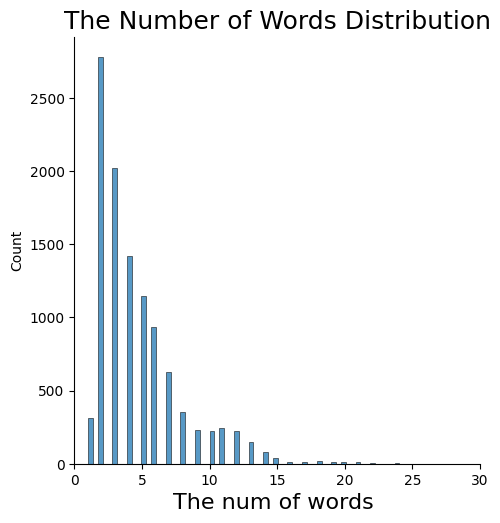

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize= (8, 8))

sns.displot(df['count'])

plt.xlim(0, 30)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

In [12]:
category_count = df['category'].value_counts()

categories = category_count.index

categories

Index(['cars', 'others', 'property'], dtype='object', name='category')

In [13]:
category_count

category
cars        8048
others      1958
property     858
Name: count, dtype: int64

In [14]:
category_count.index

Index(['cars', 'others', 'property'], dtype='object', name='category')

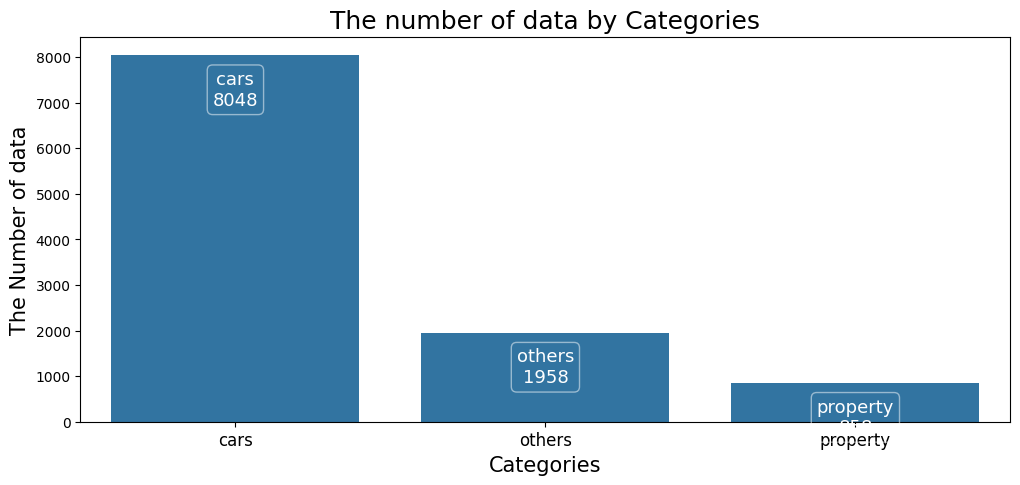

In [15]:
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )

plt.xlabel('Categories', size = 15)

plt.ylabel('The Number of data', size= 15)

plt.xticks(size = 12)

plt.title("The number of data by Categories" , size = 18)

plt.show()

In [16]:
df['category'].unique()

array(['cars', 'property', 'others'], dtype=object)

In [17]:
# ================================================================================================================================================

In [18]:

df['encoded_text'] = df['category'].astype('category').cat.codes
data_texts = df['text'].to_list()
data_labels = df['encoded_text'].to_list()
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=0)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.01, random_state=0)


In [19]:
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [20]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors='pt')
val_encodings = tokenizer(val_texts, truncation=True, padding=True, return_tensors='pt')
test_encodings = tokenizer(test_texts, truncation=True, padding=True, return_tensors='pt')


In [21]:
train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    torch.tensor(train_labels)
)

val_dataset = TensorDataset(
    val_encodings['input_ids'],
    val_encodings['attention_mask'],
    torch.tensor(val_labels)
)

test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    torch.tensor(test_labels)
)

In [22]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [23]:
# Load pre-trained DistilBERT model for sequence classification
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=5)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=3e-5)
num_epochs = 15
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * num_epochs)


c:\Users\DEV1\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()


In [26]:
# Evaluation on validation set
model.eval()
val_loss = 0.0
correct_preds = 0
total_preds = 0


In [27]:
with torch.no_grad():
    for batch in val_dataloader:
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        val_loss += outputs.loss.item()
        predicted_labels = torch.argmax(outputs.logits, dim=1)
        correct_preds += (predicted_labels == labels).sum().item()
        total_preds += len(labels)

In [28]:
val_accuracy = correct_preds / total_preds
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")


# Validation Loss (0.5547):
# The validation loss is the measure of the error your model makes on the validation set. A lower loss indicates better performance. However, the absolute value of the loss can vary depending on the loss function used and the scale of your data.
# A validation loss of approximately 0.5547 is relatively low, indicating that your model is making small errors on average.


# Validation Accuracy (99.72%):
# The validation accuracy indicates the proportion of correct predictions your model makes on the validation set. An accuracy of 99.72% means that your model correctly classifies 99.72% of the validation data.
# Such a high accuracy is indicative of excellent performance on the validation set.

Validation Loss: 1.3470506948324328, Validation Accuracy: 0.9935572940635067


In [29]:
# Save the fine-tuned model and tokenizer
save_directory = "./ClassificationModel_version10"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('./ClassificationModel_version10\\tokenizer_config.json',
 './ClassificationModel_version10\\special_tokens_map.json',
 './ClassificationModel_version10\\vocab.json',
 './ClassificationModel_version10\\merges.txt',
 './ClassificationModel_version10\\added_tokens.json')

In [2]:
# Load the saved tokenizer and model
save_directory = "./ClassificationModel_version10"
# loaded_tokenizer = DistilBertTokenizer.from_pretrained(save_directory)
# loaded_model = DistilBertForSequenceClassification.from_pretrained(save_directory)

loaded_tokenizer = RobertaTokenizer.from_pretrained(save_directory)
loaded_model = RobertaForSequenceClassification.from_pretrained(save_directory)




In [5]:
# New input text
# new_input_text = "hp laptop with 250 $"
# new_input_text = "3-bedroom condo with at least 2 bathrooms"
new_input_text = "apartment with great view"

# Tokenize the input text
input_encoding = loaded_tokenizer(new_input_text, truncation=True, padding=True, return_tensors='pt')

# Make a prediction
with torch.no_grad():
    output = loaded_model(**input_encoding)

# Get predicted label
predicted_label = torch.argmax(output.logits, dim=1).item()

if int(predicted_label) == 0 :
    print("Predicted category: Cars")

if int(predicted_label) == 1 :
    print("Predicted category: Others")

if int(predicted_label) == 2 :
    print("Predicted category: Property")



Predicted category: Property
